# Setup environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.4.1-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

In [ ]:
try:
    sc = ps.SparkContext('local')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


/content/spark-3.4.1-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
sc.master

'local'

In [ ]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/drive/MyDrive/Hotel_Reviews.csv')
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.show(5)

+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------

In [ ]:
df.count()

515738

In [ ]:
dataCollect = df.collect()
type(dataCollect)

list

In [ ]:
dataCollect[0][6]

' I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin y

In [ ]:
dataCollect[0][9]

' Only the park outside of the hotel was beautiful '

In [ ]:
data = []
for row in dataCollect:
  neg_review = row[6].strip()
  pos_review = row[9].strip()
  if neg_review != 'No Negative':
    data.append([neg_review, 0])
  if pos_review != 'No Positive':
    data.append([pos_review, 1])

In [ ]:
data[0]

['I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin y

In [ ]:
len(data)

867640

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').getOrCreate()
pandasDF = pd.DataFrame(data, columns = ['Review', 'Score'])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(pandasDF, test_size=0.2, random_state=42)

In [ ]:
train_set = spark.createDataFrame(train_df)
test_set = spark.createDataFrame(test_df)

In [ ]:
print(train_set.count())
print(test_set.count())

694112
173528


In [ ]:
type(train_set)

pyspark.sql.dataframe.DataFrame

In [ ]:
train_set.show(5)

+--------------------+-----+
|              Review|Score|
+--------------------+-----+
|Friendly staff Lo...|    1|
|For a four star h...|    0|
|Location Heating ...|    1|
|We had an executi...|    1|
|We booked this ho...|    0|
+--------------------+-----+
only showing top 5 rows



# Experiment with models: Logistic Regression, NaiveBayes, SVM

## HashingTF + IDF

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from datetime import datetime

tokenizer = Tokenizer(inputCol="Review", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "Score", outputCol = "label")
pipeline1 = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

st = datetime.utcnow()
pipelineFit1 = pipeline1.fit(train_set)
train_df1 = pipelineFit1.transform(train_set)
test_df1 = pipelineFit1.transform(test_set)
print('Preparation time:', datetime.utcnow() - st)
train_df1.show(5)

Preparation time: 0:00:34.014211
+--------------------+-----+--------------------+--------------------+--------------------+-----+
|              Review|Score|               words|                  tf|            features|label|
+--------------------+-----+--------------------+--------------------+--------------------+-----+
|Friendly staff Lo...|    1|[friendly, staff,...|(65536,[7805,3030...|(65536,[7805,3030...|  0.0|
|For a four star h...|    0|[for, a, four, st...|(65536,[2323,9712...|(65536,[2323,9712...|  1.0|
|Location Heating ...|    1|[location, heatin...|(65536,[7805,1165...|(65536,[7805,1165...|  0.0|
|We had an executi...|    1|[we, had, an, exe...|(65536,[9712,1213...|(65536,[9712,1213...|  0.0|
|We booked this ho...|    0|[we, booked, this...|(65536,[1981,3186...|(65536,[1981,3186...|  1.0|
+--------------------+-----+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

Logistic Regression training time: 0:01:25.628884
Accuracy: 0.9333248812871698
Precision: 0.9334213614876694
Recall: 0.9333248812871698


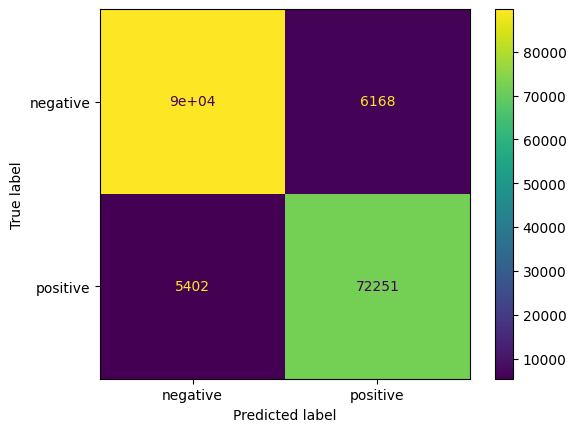

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from pyspark.ml.classification import LogisticRegression
lr1 = LogisticRegression(maxIter=100)

st = datetime.utcnow()
lr_Model1 = lr1.fit(train_df1)
print('Logistic Regression training time:', datetime.utcnow() - st)
lr_predictions1 = lr_Model1.transform(test_df1)
lr_accuracy1 = evaluator.evaluate(lr_predictions1, {evaluator.metricName: "accuracy"})
lr_precision1 = evaluator.evaluate(lr_predictions1, {evaluator.metricName: "weightedPrecision"})
lr_recall1 = evaluator.evaluate(lr_predictions1, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", lr_accuracy1)
print("Precision:", lr_precision1)
print("Recall:", lr_recall1)

y_true = lr_predictions1.select(['label']).collect()
y_pred = lr_predictions1.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Naive Bayes training time: 0:00:20.336710
Accuracy: 0.9104524918168826
Precision: 0.9104141421530348
Recall: 0.9104524918168826


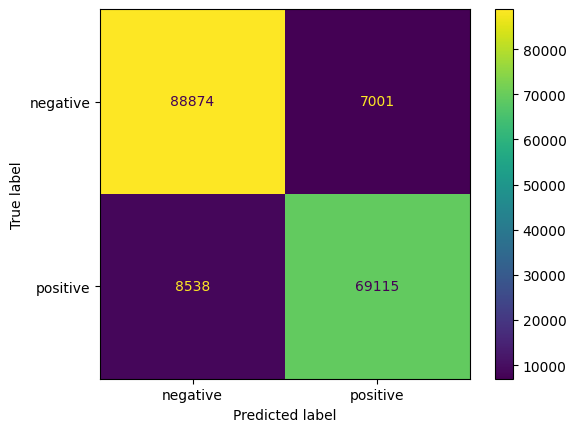

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb1 = NaiveBayes(modelType="multinomial")

st = datetime.utcnow()
nb_Model1 = nb1.fit(train_df1)
print('Naive Bayes training time:', datetime.utcnow() - st)
nb_predictions1 = nb_Model1.transform(test_df1)
nb_accuracy1 = evaluator.evaluate(nb_predictions1, {evaluator.metricName: "accuracy"})
nb_precision1 = evaluator.evaluate(nb_predictions1, {evaluator.metricName: "weightedPrecision"})
nb_recall1 = evaluator.evaluate(nb_predictions1, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", nb_accuracy1)
print("Precision:", nb_precision1)
print("Recall:", nb_recall1)

y_true = nb_predictions1.select(['label']).collect()
y_pred = nb_predictions1.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

SVM training time: 0:02:27.787200
Accuracy: 0.9363272785948089
Precision: 0.9364788037955695
Recall: 0.9363272785948089


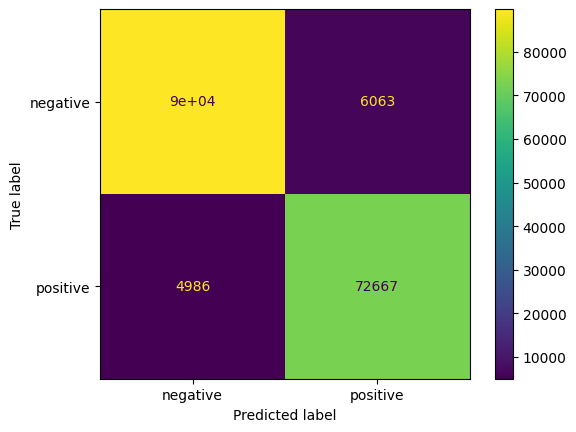

In [ ]:
from pyspark.ml.classification import LinearSVC
svm1 = LinearSVC()

st = datetime.utcnow()
svm_Model1 = svm1.fit(train_df1)
print('SVM training time:', datetime.utcnow() - st)
svm_predictions1 = svm_Model1.transform(test_df1)
svm_accuracy1 = evaluator.evaluate(svm_predictions1, {evaluator.metricName: "accuracy"})
svm_precision1 = evaluator.evaluate(svm_predictions1, {evaluator.metricName: "weightedPrecision"})
svm_recall1 = evaluator.evaluate(svm_predictions1, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", svm_accuracy1)
print("Precision:", svm_precision1)
print("Recall:", svm_recall1)

y_true = svm_predictions1.select(['label']).collect()
y_pred = svm_predictions1.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

## CountVectorizer + IDF

In [ ]:
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="Review", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "Score", outputCol = "label")
pipeline2 = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx])

st = datetime.utcnow()
pipelineFit2 = pipeline2.fit(train_set)
train_df2 = pipelineFit2.transform(train_set)
test_df2 = pipelineFit2.transform(test_set)
print('Preparation time:', datetime.utcnow() - st)
train_df2.show(5)

Preparation time: 0:00:26.756728
+--------------------+-----+--------------------+--------------------+--------------------+-----+
|              Review|Score|               words|                  cv|            features|label|
+--------------------+-----+--------------------+--------------------+--------------------+-----+
|Friendly staff Lo...|    1|[friendly, staff,...|(65536,[8,11,26],...|(65536,[8,11,26],...|  0.0|
|For a four star h...|    0|[for, a, four, st...|(65536,[0,2,3,4,5...|(65536,[0,2,3,4,5...|  1.0|
|Location Heating ...|    1|[location, heatin...|(65536,[11,31,57,...|(65536,[11,31,57,...|  0.0|
|We had an executi...|    1|[we, had, an, exe...|(65536,[0,1,2,5,9...|(65536,[0,1,2,5,9...|  0.0|
|We booked this ho...|    0|[we, booked, this...|(65536,[0,1,2,3,4...|(65536,[0,1,2,3,4...|  1.0|
+--------------------+-----+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



Logistic Regression training time: 0:01:13.551571
Accuracy: 0.9338781061269651
Precision: 0.9339876988878255
Recall: 0.9338781061269651


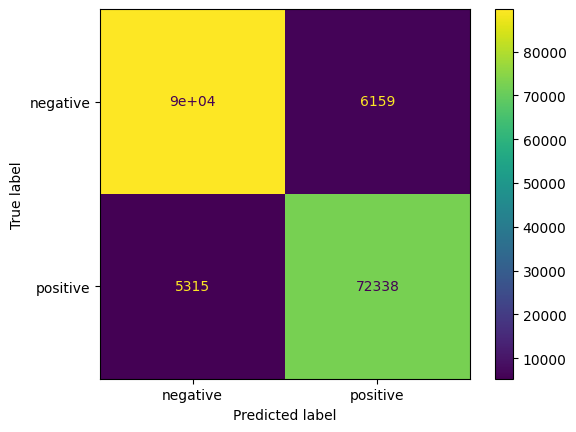

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from pyspark.ml.classification import LogisticRegression
lr2 = LogisticRegression(maxIter=100)

st = datetime.utcnow()
lr_Model2 = lr2.fit(train_df2)
print('Logistic Regression training time:', datetime.utcnow() - st)
lr_predictions2 = lr_Model2.transform(test_df2)
lr_accuracy2 = evaluator.evaluate(lr_predictions2, {evaluator.metricName: "accuracy"})
lr_precision2 = evaluator.evaluate(lr_predictions2, {evaluator.metricName: "weightedPrecision"})
lr_recall2 = evaluator.evaluate(lr_predictions2, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", lr_accuracy2)
print("Precision:", lr_precision2)
print("Recall:", lr_recall2)

y_true = lr_predictions2.select(['label']).collect()
y_pred = lr_predictions2.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Naive Bayes training time: 0:00:15.989188
Accuracy: 0.9116050435664561
Precision: 0.9115818624136838
Recall: 0.9116050435664562


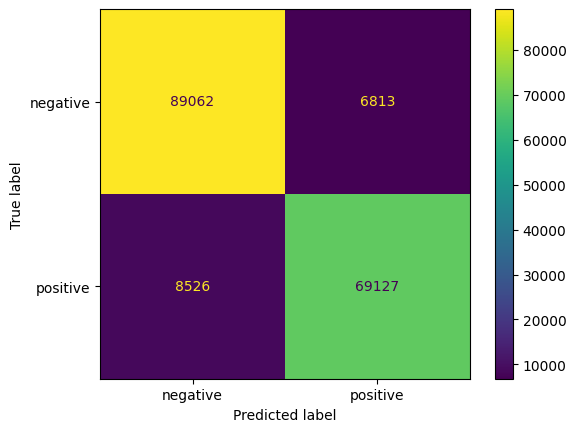

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb2 = NaiveBayes(modelType="multinomial")

st = datetime.utcnow()
nb_Model2 = nb2.fit(train_df2)
print('Naive Bayes training time:', datetime.utcnow() - st)
nb_predictions2 = nb_Model2.transform(test_df2)
nb_accuracy2 = evaluator.evaluate(nb_predictions2, {evaluator.metricName: "accuracy"})
nb_precision2 = evaluator.evaluate(nb_predictions2, {evaluator.metricName: "weightedPrecision"})
nb_recall2 = evaluator.evaluate(nb_predictions2, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", nb_accuracy2)
print("Precision:", nb_precision2)
print("Recall:", nb_recall2)

y_true = nb_predictions2.select(['label']).collect()
y_pred = nb_predictions2.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

SVM training time: 0:02:58.455589
Accuracy: 0.9373127103406943
Precision: 0.9374104719178438
Recall: 0.9373127103406942


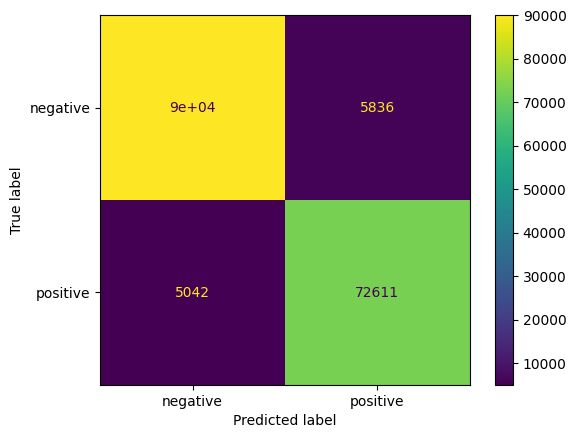

In [ ]:
from pyspark.ml.classification import LinearSVC
svm2 = LinearSVC()

st = datetime.utcnow()
svm_Model2 = svm2.fit(train_df2)
print('SVM training time:', datetime.utcnow() - st)
svm_predictions2 = svm_Model2.transform(test_df2)
svm_accuracy2 = evaluator.evaluate(svm_predictions2, {evaluator.metricName: "accuracy"})
svm_precision2 = evaluator.evaluate(svm_predictions2, {evaluator.metricName: "weightedPrecision"})
svm_recall2 = evaluator.evaluate(svm_predictions2, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", svm_accuracy2)
print("Precision:", svm_precision2)
print("Recall:", svm_recall2)

y_true = svm_predictions2.select(['label']).collect()
y_pred = svm_predictions2.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

## CountVectorizer + NGram + ChiSqSelector

In [ ]:
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

def build_trigrams(inputCol=["Review","Score"], n=3):
    tokenizer = [Tokenizer(inputCol="Review", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = "Score", outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx + selector)

In [ ]:
pipeline3 = build_trigrams()

st = datetime.utcnow()
pipelineFit3 = pipeline3.fit(train_set)
train_df3 = pipelineFit3.transform(train_set)
test_df3 = pipelineFit3.transform(test_set)
print('Preparation time:', datetime.utcnow() - st)
train_df3.show(5)

Preparation time: 0:07:02.444089
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|              Review|Score|               words|             1_grams|             2_grams|             3_grams|                1_tf|                2_tf|                3_tf|             1_tfidf|             2_tfidf|             3_tfidf|         rawFeatures|label|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|Friendly staff Lo...|    1|[friendly, staff,...|[friendly, staff,...|[friendly staff, ...|[friendly staff

Logistic Regression training time: 0:04:31.357199
Accuracy: 0.942510718731271
Precision: 0.9426153183490008
Recall: 0.9425107187312711


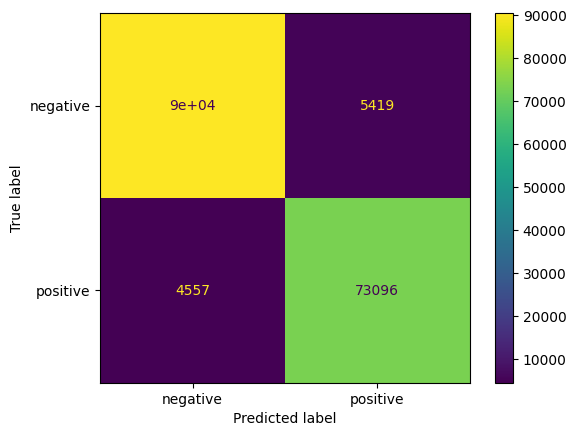

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from pyspark.ml.classification import LogisticRegression
lr3 = LogisticRegression(maxIter=100)

st = datetime.utcnow()
lr_Model3 = lr3.fit(train_df3)
print('Logistic Regression training time:', datetime.utcnow() - st)
lr_predictions3 = lr_Model3.transform(test_df3)
lr_accuracy3 = evaluator.evaluate(lr_predictions3, {evaluator.metricName: "accuracy"})
lr_precision3 = evaluator.evaluate(lr_predictions3, {evaluator.metricName: "weightedPrecision"})
lr_recall3 = evaluator.evaluate(lr_predictions3, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", lr_accuracy3)
print("Precision:", lr_precision3)
print("Recall:", lr_recall3)

y_true = lr_predictions3.select(['label']).collect()
y_pred = lr_predictions3.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Naive Bayes training time: 0:01:24.053049
Accuracy: 0.9320455488451431
Precision: 0.9323092905406152
Recall: 0.9320455488451431


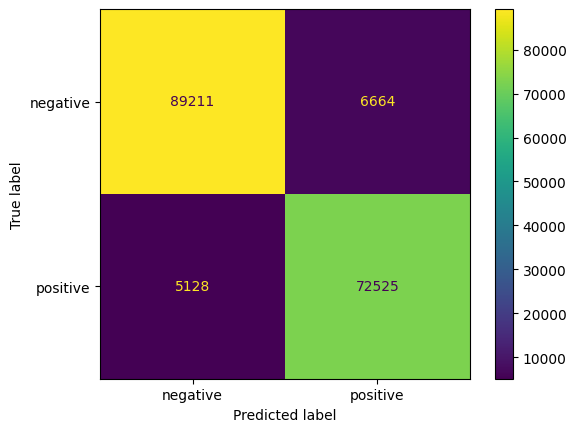

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb3 = NaiveBayes(modelType="multinomial")

st = datetime.utcnow()
nb_Model3 = nb3.fit(train_df3)
print('Naive Bayes training time:', datetime.utcnow() - st)
nb_predictions3 = nb_Model3.transform(test_df3)
nb_accuracy3 = evaluator.evaluate(nb_predictions3, {evaluator.metricName: "accuracy"})
nb_precision3 = evaluator.evaluate(nb_predictions3, {evaluator.metricName: "weightedPrecision"})
nb_recall3 = evaluator.evaluate(nb_predictions3, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", nb_accuracy3)
print("Precision:", nb_precision3)
print("Recall:", nb_recall3)

y_true = nb_predictions3.select(['label']).collect()
y_pred = nb_predictions3.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

SVM training time: 0:09:26.183230
Accuracy: 0.9450002305103499
Precision: 0.9452378400855697
Recall: 0.94500023051035


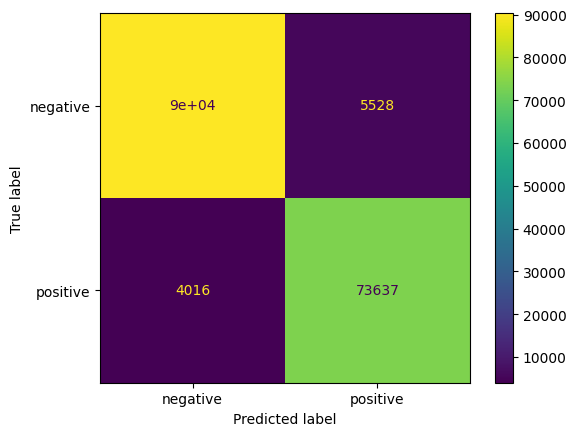

In [ ]:
from pyspark.ml.classification import LinearSVC
svm3 = LinearSVC()

st = datetime.utcnow()
svm_Model3 = svm3.fit(train_df3)
print('SVM training time:', datetime.utcnow() - st)
svm_predictions3 = svm_Model3.transform(test_df3)
svm_accuracy3 = evaluator.evaluate(svm_predictions3, {evaluator.metricName: "accuracy"})
svm_precision3 = evaluator.evaluate(svm_predictions3, {evaluator.metricName: "weightedPrecision"})
svm_recall3 = evaluator.evaluate(svm_predictions3, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", svm_accuracy3)
print("Precision:", svm_precision3)
print("Recall:", svm_recall3)

y_true = svm_predictions3.select(['label']).collect()
y_pred = svm_predictions3.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])